In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-c6f30bf8-5a0a-2891-dde8-87c70f9608a6)


In [ ]:
#!chmod 755 -R /content/drive/MyDrive/sign_language/models_keypoints/
#!/content/drive/MyDrive/sign_language/models_keypoints/getModels.sh

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/sign_language/lcrnet-v2-improved-ppi')
#from lcr_net_ppi_improved import LCRNet_PPI_improved
sys.path.append('/content/drive/MyDrive/sign_language/DOPE')
import gzip
import pickle
import sys, os
import argparse
import os.path as osp
from PIL import Image
import cv2
import numpy as np
import time

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor

from model import dope_resnet50, num_joints
import postprocess

import matplotlib.pyplot as plt

# Load features files PHOENIX

In [ ]:
def load_dataset_file(filename):
    with gzip.open(filename, "rb") as f:
        loaded_object = pickle.load(f)
        return loaded_object
def extract(tmp):
  samples = {}
  for s in tmp:
    seq_id = s["name"]
    if seq_id in samples:
        assert samples[seq_id]["name"] == s["name"]
        assert samples[seq_id]["signer"] == s["signer"]
        assert samples[seq_id]["gloss"] == s["gloss"]
        assert samples[seq_id]["text"] == s["text"]
        samples[seq_id]["sign"] = torch.cat(
            [samples[seq_id]["sign"], s["sign"]], axis=1
        )
    else:
        samples[seq_id] = {
            "name": s["name"],
            "signer": s["signer"],
            "gloss": s["gloss"],
            "text": s["text"],
            "sign": s["sign"],
        }
  return samples

## TRAIN

In [ ]:
tmp = load_dataset_file('/content/drive/MyDrive/sign_language/data/phoenix14t.pami0.train')
samples_train = extract(tmp)

In [ ]:
tmp = load_dataset_file('/content/drive/MyDrive/sign_language/data/phoenix14t.pami0.traincnn1')
samples_train = extract(tmp)

In [ ]:
tmp['train/05October_2010_Tuesday_heute-1210']['cnn_features_avg'].shape

torch.Size([61, 1024])

## DEV

In [ ]:
tmp = load_dataset_file('/content/drive/MyDrive/sign_language/data/phoenix14t.pami0.dev')
samples_dev = extract(tmp)

## TEST

In [ ]:
tmp = load_dataset_file('/content/drive/MyDrive/sign_language/data/phoenix14t.pami0.test')
samples_test = extract(tmp)

# DOPE EXTRACTOR

In [ ]:
""" LCR-Net: Localization-Classification-Regression for Human Pose
Copyright (C) 2020 NAVER Corp.
â€‹
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
â€‹
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
â€‹
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>"""

import numpy as np

"""
2D boxes are N*4 numpy arrays (float32) with each row at format <xmin> <ymin> <xmax> <ymax>
"""

def area2d(b):
    """ compute the areas for a set of 2D boxes"""
    return (b[:,2]-b[:,0]+1)*(b[:,3]-b[:,1]+1)

def overlap2d(b1, b2):
    """ compute the overlaps between a set of boxes b1 and 1 box b2 """
    xmin = np.maximum( b1[:,0], b2[:,0] )
    xmax = np.minimum( b1[:,2]+1, b2[:,2]+1)
    width = np.maximum(0, xmax-xmin)
    ymin = np.maximum( b1[:,1], b2[:,1] )
    ymax = np.minimum( b1[:,3]+1, b2[:,3]+1)
    height = np.maximum(0, ymax-ymin)   
    return width*height          

def iou2d(b1, b2):
    """ compute the IoU between a set of boxes b1 and 1 box b2"""
    if b1.ndim == 1: b1 = b1[None,:]
    if b2.ndim == 1: b2 = b2[None,:]
    assert b2.shape[0]==1
    o = overlap2d(b1, b2)
    return o / ( area2d(b1) + area2d(b2) - o ) 



def convert_to_ppi_format(scores, boxes, pose2d, pose3d, score_th=None, tonumpy=True, hand=False):
  if score_th is None: 
        if hand:
            score_th = 0.02/(scores.shape[1]-1)
        else:
            score_th = 0.1/(scores.shape[1]-1)
  boxindices, idxlabels = np.where(scores[:,1:]>=score_th) # take the Ndet values with scores over a threshold
  s_scores = scores[boxindices, 1+idxlabels] # Ndet (number of estimations with score over score_th)
  s_boxes = boxes[boxindices,:]  # Ndetx4 (does not depend on label)
  s_pose2d = pose2d[boxindices, idxlabels, : ,:] # NdetxJx2
  s_pose3d = pose3d[boxindices, idxlabels, : ,:] # NdetxJx3
  return s_scores, s_boxes, s_pose2d, s_pose3d, boxindices, idxlabels 

indTorsoHead = {13: [4,5,10,11,12], 14: [4,5,10,11,12,13]}
indLower     = {13: range(0,4), 14: range(0,4)}  # indices of joints for lower body
indUpper     = {13: range(4,13), 14: range(4,14)}  # indices of joints for upper body

def LCRNet_PPI_improved(scores, boxes, pose2d, pose3d, resolution, K=None, score_th=None, th_pose3D=0.3, th_iou=0.2, iou_func='bbox', min_mode_score=0.05, th_persondetect=0.002, verbose=False, hand=False):
    """
    this function extends the Pose Proposals Integration (PPI) from LCR-Net in order to also handle hands (J=21), faces (J=84) and bodies with 13 or 14 joints.    
    
    scores, boxes, pose2d, pose3d are numpy arrays of size [Nboxes x (Nclasses+1)], [Nboxes x 4], [Nboxes x Nclasses x J x 2] and [Nboxes x Nclasses x J x 3] resp.
   
    resolution: tuple (height,width) containing image resolution
    K: number of classes, without considering lower/upper (K=10)
    score_th: only apply ppi on pose proposals with score>=score_th (None => 0.1/K)
    th_pose3D: threshold for groupind pose in a mode, based on mean dist3D of the joints
    th_iou: 2D overlap threshold to group the pose proposals
    iou_func: how 2d overlap is defined 
    min_mode_score: we consider modes with at least this score (save time and do not affect 1st mode)
    th_persondetect: we remove final detection whose cumscore is below this threshold

    return a list of detection with the following fields:
      * score: cumulative score of the detection
      * pose2d: Jx2 numpy array
      * pose3d: Jx3 numpy array
    """
    if K is None: K = scores.shape[1]
    s_scores, s_boxes, s_pose2d, s_pose3d, boxindices, idxlabels = convert_to_ppi_format(scores, boxes, pose2d, pose3d, score_th=score_th, hand=hand)
  
    H,W = resolution
    wh = np.array([[W,H]], dtype=np.float32)
    J = s_pose2d.shape[1]
    if not J in [13,14]: assert iou_func in ['bbox', 'mje']

    # compute bounding boxes from 2D poses truncated by images boundaries
    if iou_func=='bbox_torsohead': # using torso+head keypoints only    
        xymin = np.minimum( wh-1, np.maximum(0, np.min(s_pose2d[:,indTorsoHead[J],:], axis=1)))
        xymax = np.minimum( wh-1, np.maximum(0, np.max(s_pose2d[:,indTorsoHead[J],:], axis=1)))
        bbox_headtorso = np.concatenate( (xymin,xymax), axis=1)
    else:  # using all keypoints
        xymin = np.minimum( wh-1, np.maximum(0, np.min(s_pose2d, axis=1)))
        xymax = np.minimum( wh-1, np.maximum(0, np.max(s_pose2d, axis=1)))
        bboxes = np.concatenate( (xymin,xymax), axis=1)
    # define iou metrics
    def compute_overlapping_poses(bboxes, poses2d, a_bbox, a_pose2d, th_iou):
        assert a_pose2d.ndim==2 and a_bbox.ndim==1
        a_bbox = a_bbox[None,:]
        a_pose2d = a_pose2d[None,:,:]
        assert bboxes.ndim==2 and poses2d.ndim==3
        if iou_func=='bbox' or iou_func=='bbox_torsohead':
            iou = iou2d(bboxes, a_bbox)
            return np.where( iou>th_iou )[0]
        elif iou_func=='torso' or iou_func=='torsoLR':
            indices = [4,5,10,11]
            lr_indices = [5,4,11,10]
        elif iou_func=='torsohead' or iou_func=='torsoheadLR':
            indices = [4,5,10,11,12] if J==13 else [4,5,10,11,12,13]
            lr_indices = [5,4,11,10,12]  if J==13 else [5,4,11,10,12,13]
        elif iou_func=='head':
            indices = [12]  if J==13 else [12,13]
        elif iou_func=='shoulderhead' or iou_func=='shoulderheadLR':
            indices = [10,11,12]  if J==13 else [10,11,12,13]
            lr_indices = [11,10,12]  if J==13 else [11,10,12,13]
        elif iou_func=='mje':
            indices = list(range(J))
        else:
            raise NotImplementedError('ppi.py: unknown iou_func')
        indices = np.array(indices, dtype=np.int32)
        if iou_func.endswith('LR'):
            lr_indices = np.array(lr_indices, dtype=np.int32)
            a = np.minimum( np.mean(np.sqrt( np.sum( (poses2d[:,   indices,:]-a_pose2d[:,indices,:])**2, axis=2)), axis=1),
                            np.mean(np.sqrt( np.sum( (poses2d[:,lr_indices,:]-a_pose2d[:,indices,:])**2, axis=2)), axis=1) )
        else:
            a = np.mean(np.sqrt(np.sum( (poses2d[:,indices,:]-a_pose2d[:,indices,:])**2, axis=2)), axis=1)
        b = 2*np.max( a_bbox[:,2:4]-a_bbox[:,0:2]+1 )
        return np.where( a/b < th_iou)[0]

  
    # group pose proposals according to 2D IoU
    Persons = [] # list containing the detected people, each person being a tuple ()
    remaining_pp = range( s_pose2d.shape[0] )
    while len(remaining_pp)>0:
        # take highest remaining score
        imax = np.argmax( s_scores[remaining_pp] )
        # consider the pose proposals with high 2d overlap
        this = compute_overlapping_poses( s_boxes[remaining_pp,:], s_pose2d[remaining_pp,:], s_boxes[remaining_pp[imax],:], s_pose2d[remaining_pp[imax],:,:], th_iou)
        this_pp = np.array(remaining_pp, dtype=np.int32)[this]
        # add the person and delete the corresponding pp
        Persons.append( (this_pp, np.sum(s_scores[this_pp])) )
        remaining_pp = [p for p in remaining_pp if not p in this_pp]
    if verbose: print("{:d} persons/groups of poses found".format(len(Persons)))


    Detected = []
    mode_isright = []
    mode_isleft = []
    # find modes for each person
    for iperson, (pplist, cumscore) in enumerate(Persons):

        remaining_pp = list(pplist.copy()) # create a copy, list of pp that are not assigned to any mode
        Modes = []

        while len(remaining_pp)>0:

            # next anchor pose mode is defined as the top regscore among unassigned poses
            imax = np.argmax( s_scores[remaining_pp] )
            maxscore = s_scores[remaining_pp[imax]]
            if maxscore<min_mode_score and len(Modes)>0: break # stop if score not sufficiently high and already created a mode
            # select PP (from the entire set) close to the center of the mode
            mode_pose3D = s_pose3d[ remaining_pp[imax], :,:]
            #dist3D = np.mean( np.sqrt( (mode_pose3D[ 0:13]-regpose3d[pplist, 0:13])**2 + \
            #                           (mode_pose3D[13:26]-regpose3d[pplist,13:26])**2 + \
            #                           (mode_pose3D[26:39]-regpose3d[pplist,26:39])**2 ), axis=1)
            dist3D = np.mean(np.sqrt( np.sum( (mode_pose3D-s_pose3d[pplist,:,:])**2, axis=2)), axis=1)
            this = np.where( dist3D < th_pose3D )[0]
            
            # compute the output for this mode
            this_pp = pplist[this]            
            weights = s_scores[this_pp]            
            
            # upper body is average weights by the scores
            hand_isright = None
            if J in [13,14]:
                p3d = np.empty( (J,3), dtype=np.float32)
                p2d = np.empty( (J,2), dtype=np.float32)
                cumscore = np.sum(weights)
                p3d[ indUpper[J], :] = np.sum(weights[:,None,None] * s_pose3d[this_pp,:,:][:,indUpper[J],:], axis=0) / cumscore
                p2d[ indUpper[J], :] = np.sum(weights[:,None,None] * s_pose2d[this_pp,:,:][:,indUpper[J],:], axis=0) / cumscore
                
                assert idxlabels is not None
                # for lower body, we downweight upperbody scores
                this_ub = np.where(idxlabels[this_pp]> K)[0] # anchor pose for upper body
                weights[ this_ub ] *= 0.1
                cumscoreBot = np.sum(weights)
                p3d[ indLower[J], :] = np.sum(weights[:,None,None] * s_pose3d[this_pp,:,:][:,indLower[J],:], axis=0) / cumscoreBot
                p2d[ indLower[J], :] = np.sum(weights[:,None,None] * s_pose2d[this_pp,:,:][:,indLower[J],:], axis=0) / cumscoreBot
            else:
                cumscore = np.sum(weights)
                p3d = np.sum(weights[:,None,None] * s_pose3d[this_pp,:,:], axis=0) / cumscore
                p2d = np.sum(weights[:,None,None] * s_pose2d[this_pp,:,:], axis=0) / cumscore
                if J==21:
                    hand_isright = (idxlabels[imax] < K)
              
            this_mode = {'score': cumscore, 'pose3d': p3d, 'pose2d': p2d}
            if hand_isright is not None: this_mode['hand_isright'] = hand_isright
            Modes.append( this_mode ) 
            
            # remove pp from the list to process
            remaining_pp = [p for p in remaining_pp if not p in this_pp]
        if verbose: print("Person {:d}/{:d} has {:d} mode(s)".format(iperson+1, len(Persons), len(Modes)))
        if hand is False: 
            # keep the main mode for each person, only if score is sufficient high
            modes_score = np.array([m['score'] for m in Modes])
            bestmode = np.argmax( modes_score )
            if modes_score[bestmode] > th_persondetect:
                Detected.append( Modes[bestmode] )
            else:
                if verbose: print("\tdeleting this person because of too low score")
        else:
            mode_isright += [m for m in Modes if m['hand_isright']==True]
            mode_isleft += [m for m in Modes if m['hand_isright']==False]
    if hand is True:
      res = mode_isright + mode_isleft
      res.sort(key=lambda d: d['score'], reverse=True)
      Detected.append(res[0])

    if verbose: print('{:d} person(s) detected'.format(len(Detected)))
    # sort detection according to score
    Detected.sort( key=lambda d: d['score'], reverse=True)
    return Detected

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
     
# load model
ckpt_fname = '/content/drive/MyDrive/sign_language/models/DOPE_v1_0_0.pth.tgz'
ckpt = torch.load(ckpt_fname, map_location=device)
ckpt['dope_kwargs']['rpn_post_nms_top_n_test'] = 1000
model = dope_resnet50(**ckpt['dope_kwargs'])
if ckpt['half']: 
  model = model.half()
model = model.eval()
model.load_state_dict(ckpt['state_dict'])
model = model.to(device)

In [ ]:
ToTensor()(images[0]).to(device)[None,:,:,:].shape

torch.Size([1, 3, 260, 210])

In [ ]:
model.transform.training = False 

In [ ]:
out, targets = model.transform(ToTensor()(images[0]).to(device)[None,:,:,:], None)
#f = model.backbone(ToTensor()(images[0]).to(device)[None,:,:,:])

In [ ]:
f = model.backbone(out.tensors)

In [ ]:
from torchvision.models import resnet50

In [ ]:
shape2d = {'face': (84, 2), 'hand': (21, 2), 'body': (13, 2)}
shape3d =  {'face': (84, 3), 'hand': (21, 3), 'body': (13, 3)}
def extractor(image):
    if isinstance(image, str):     
      image = np.array(Image.open(image))[...,:3]
    imlist = [ToTensor()(image).to(device)]
    if ckpt['half']: imlist = [im.half() for im in imlist]
    resolution = imlist[0].size()[-2:]
    
    # forward pass of the dope network
    with torch.no_grad():
        outputs = model(imlist, None)
        results, add_features = outputs[0][0], outputs[1]
    # postprocess results (pose proposals integration, wrists/head assignment)
    parts = ['body','hand','face']
    res = {k: v.float().data.cpu().numpy() for k,v in results.items()}
    detections = {}
    for part in parts:
      detections[part] = LCRNet_PPI_improved(res[part+'_scores'], res['boxes'], res[part+'_pose2d'], res[part+'_pose3d'], resolution, **ckpt[part+'_ppi_kwargs'], hand=(part=='hand'))
    # assignment of hands and head to body
    detections, body_with_wrists, body_with_head = postprocess.assign_hands_and_head_to_body(detections)
    for part in parts:
      detections[part] += [{'score': -10, 'pose3d': np.zeros(shape3d[part]), 'pose2d': np.zeros(shape2d[part])}]
    return detections,  add_features

def extractor_features(images):
    #if isinstance(image, str):     
      #image = np.array(Image.open(image))[...,:3]
    imlist = [ToTensor()(image).to(device) for image in images]
    if ckpt['half']: imlist = [im.half() for im in imlist]
    resolution = imlist[0].size()[-2:]

    # forward pass of the dope network
    with torch.no_grad():
        outputs = model(imlist, None)
        del imlist
        torch.cuda.empty_cache()
        results, features = outputs[0][0], outputs[1]
    return features['0']

# OUTPUT ANALYSIS

In [ ]:
detections_2, add_f = extractor('/content/drive/MyDrive/sign_language/DOPE_test/test2.jpg')

In [ ]:
detections_2

In [ ]:
detections_1, add_f = extractor('/content/drive/MyDrive/sign_language/DOPE_test/test1.jpg')

In [ ]:
detections_1

In [ ]:
detections, add_f = extractor('/content/drive/MyDrive/sign_language/DOPE_test/test.jpg')

In [ ]:
detections

In [ ]:
print('Body tensor shape:')
print(f"2D : {detections_2['body'][0]['pose2d'].shape} / 3D : {detections_2['body'][0]['pose3d'].shape}")
print('Hand tensor shape:')
print(f"2D : {detections_2['hand'][0]['pose2d'].shape} / 3D : {detections_2['hand'][0]['pose3d'].shape}")
print('Face tensor shape:')
print(f"2D : {detections_2['face'][0]['pose2d'].shape} / 3D : {detections_2['face'][0]['pose3d'].shape}")

Body tensor shape:
2D : (13, 2) / 3D : (13, 3)
Hand tensor shape:
2D : (21, 2) / 3D : (21, 3)
Face tensor shape:
2D : (84, 2) / 3D : (84, 3)


Feature normalization for bodypoint (4.2) : https://arxiv.org/pdf/1811.11436.pdf

@TODO : How are we going to transform bodypoint to features ? 

# Examples

In [ ]:
abs_path = '/content/drive/MyDrive/sign_language/data/'
#path_vid = 'train/01August_2011_Monday_heute-4858.mp4'
#path_vid = 'train/11August_2010_Wednesday_tagesschau-1.mp4'
path_vid = 'dev/16May_2010_Sunday_tagesschau-5227.mp4'
vidcap = cv2.VideoCapture(abs_path + path_vid)
success,image = vidcap.read()
count = 0
images = []
while success:
  images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1
len(images)

184

In [ ]:
for i in range(111):
  test, test_ = extractor(images[i])
  if len(test['face']) < 1:
    print(i)

80


In [ ]:
test, test_ = extractor(images[80])

2.1511087
0.008291957
0.0135074705
0.06824436


In [ ]:
f = extractor_features([images[80]]*2)

In [ ]:
f.flatten(start_dim=1).shape

torch.Size([40, 3174400])

In [ ]:
torch.cat([f.flatten(start_dim=1), f.flatten(start_dim=1)]).shape

torch.Size([80, 3174400])

In [ ]:
a = nn.AvgPool2d(kernel_size=6, stride=6, padding=0, ceil_mode=False,
            count_include_pad=False)

In [ ]:
a_ = nn.AdaptiveMaxPool2d((1,1))

In [ ]:
b = a_(f)

In [ ]:
b.shape

torch.Size([2, 1024, 1, 1])

In [ ]:
b.flatten(start_dim=1).shape

torch.Size([2, 1024])

In [ ]:
del f
torch.cuda.empty_cache()

In [ ]:
import sys
sys.getsizeof(b.flatten(start_dim=1).detach().cpu())

72

### Test HandKeyPointDetector

In [ ]:
protoFile = "/content/hand/pose_deploy.prototxt.txt"
weightsFile = "/content/hand/pose_iter_102000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [ ]:
frame = images[0]
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
aspect_ratio = frameWidth/frameHeight

threshold = 0.01

t = time.time()
# input image dimensions for the network
inHeight = 368
inWidth = int(((aspect_ratio*inHeight)*8)//8)
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))

time taken by network : 2.547


In [ ]:
# Empty list to store the detected keypoints
threshold = 0.1
points = []
nPoints = 22
for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frameWidth, frameHeight))

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    if prob > threshold :
        cv2.circle(frameCopy, (int(point[0]), int(point[1])), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(point[0]), int(point[1])))
    else :
        points.append(None)


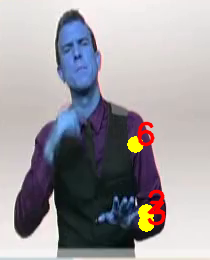

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(frameCopy)

BIG FAIL !!!

## Continue

In [ ]:
test['hand'][0]['pose2d'].shape

(21, 2)

In [ ]:
all_features = extractor(images[23], return_f_only=True)

In [ ]:
all_features[0]['hand'].shape # I will ignore it

torch.Size([95, 11])

In [ ]:
all_features[0]['face'].shape # I will ignore it

torch.Size([79, 11])

In [ ]:
all_features[0]['body'].shape # I will ignore it

torch.Size([79, 21])

In [ ]:
all_features[1]['hand'].shape 

torch.Size([79, 10, 105])

In [ ]:
all_features[1]['face'].shape

torch.Size([79, 10, 420])

In [ ]:
all_features[1]['body'].shape

torch.Size([79, 20, 65])

In [ ]:
all_features[2].shape

torch.Size([95, 2048])

In [ ]:
all_features[3]['0'].shape

torch.Size([1, 1024, 62, 50])

# Capturing Frames

In [ ]:
avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

## Slow Version

In [ ]:
def capture_frames(path_vid):
  vidcap = cv2.VideoCapture(path_vid)
  success,image = vidcap.read()
  count = 0
  frames = []
  while success:
    frames.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))    
    success,image = vidcap.read()
    count += 1
  return frames

def extract_features_from_frames(frames):
  for frame in frames:
    start = time.time()
    keypoints, features = extractor(frame)
    end = time.time()
    start = time.time()
    f_2d, b_2d, h_2d = decode_keypoints_2d(keypoints)
    f_3d, b_3d, h_3d = decode_keypoints_3d(keypoints)
    f_postroi, f_preroi = decode_features(features)
    try:
      face_2d = torch.cat((face_2d, f_2d), 0)
      body_2d = torch.cat((body_2d, b_2d), 0)
      hand_2d = torch.cat((hand_2d, h_2d), 0)
      face_3d = torch.cat((face_3d, f_3d), 0)
      body_3d = torch.cat((body_3d, b_3d), 0)
      hand_3d = torch.cat((hand_3d, h_3d), 0)
      post_roi.append(f_postroi)
      pre_roi = torch.cat((pre_roi, f_preroi), 0)
    except NameError:
      face_2d, body_2d, hand_2d, post_roi, pre_roi = f_2d, b_2d, h_2d, [f_postroi], f_preroi
      face_3d, body_3d, hand_3d = f_3d, b_3d, h_3d
    end = time.time()
  return {'body2d': body_2d, 'hand2d': hand_2d, 'face2d': face_2d, 'body3d': body_3d,
          'hand3d': hand_3d, 'face3d': face_3d, 'postroi':post_roi, 'preroi': pre_roi}

def decode_features(features):
  f_postroi, f_preroi = features[0].detach().cpu(), features[1]['0'].detach().cpu()
  return f_postroi, f_preroi

def decode_keypoints_2d(keypoints):
  f_2d = torch.tensor(keypoints['face'][0]['pose2d'])[None, :, :]
  b_2d = torch.tensor(keypoints['body'][0]['pose2d'])[None, :, :]
  h_2d = torch.tensor(keypoints['hand'][0]['pose2d'])[None, :, :]
  return f_2d, b_2d, h_2d

def decode_keypoints_3d(keypoints):
  f_3d = torch.tensor(keypoints['face'][0]['pose3d'])[None, :, :]
  b_3d = torch.tensor(keypoints['body'][0]['pose3d'])[None, :, :]
  h_3d = torch.tensor(keypoints['hand'][0]['pose3d'])[None, :, :]
  return f_3d, b_3d, h_3d

In [ ]:
## WE MUST DETACH FROM GPU
def capture_frames(path_vid):
  vidcap = cv2.VideoCapture(path_vid)
  success,image = vidcap.read()
  count = 0
  frames = []
  while success:
    frames.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))    
    success,image = vidcap.read()
    count += 1
  return frames

def extract_features_from_frames(frames):
  dct = {'hand_2d': [], 'hand_3d': [], 'body_2d': [], 'body_3d': [], 
          'face_2d': [], 'face_3d': []} #'preroi': [], 'postroi': []}
  for frame in frames:
    keypoints, features = extractor(frame)
    del features
    torch.cuda.empty_cache()
    #dct['preroi'].append(features[1]['0'].detach().cpu().numpy())
    #dct['postroi'].append(features[0].detach().cpu().numpy())
    dct['hand_2d'].append(keypoints['hand'][0]['pose2d'])
    dct['hand_3d'].append(keypoints['hand'][0]['pose3d'])
    dct['face_2d'].append(keypoints['face'][0]['pose2d'])
    dct['face_3d'].append(keypoints['face'][0]['pose3d'])
    dct['body_2d'].append(keypoints['body'][0]['pose2d'])
    dct['body_3d'].append(keypoints['body'][0]['pose3d'])
  return {k: np.array(v) for k,v in dct.items()}

## Fast version (only resnet features)

In [ ]:
def divide_chunks(l, n):  
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [ ]:
avgpool = nn.AdaptiveAvgPool2d((1,1))
maxpool = nn.AdaptiveMaxPool2d((1,1))
def capture_frames(path_vid):
  vidcap = cv2.VideoCapture(path_vid)
  success,image = vidcap.read()
  count = 0
  frames = []
  while success:
    frames.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))    
    success,image = vidcap.read()
    count += 1
  return frames

def extract_features_from_frames(frames):
  all_avg, all_max = [], []
  for batch_frame in divide_chunks(frames, 45):
    features = extractor_features(batch_frame)
    all_avg.append(avgpool(features).flatten(start_dim=1).detach().cpu())
    all_max.append(maxpool(features).flatten(start_dim=1).detach().cpu())
  cnnfeatures_avg = torch.cat(all_avg)
  cnnfeatures_max = torch.cat(all_max)
  return cnnfeatures_avg, cnnfeatures_max

## Valid

In [ ]:
samples_dev_copy = samples_dev.copy()

In [ ]:
from tqdm import tqdm_notebook as tqdm
already_done = []
abs_path = '/content/drive/MyDrive/sign_language/data/'
for key in tqdm(samples_dev.keys()):
  path_vid = abs_path + key + '.mp4'
  frames = capture_frames(path_vid)
  assert len(frames) == len(samples_dev[key]['sign'])
  samples_dev_copy[key]['cnn_features_avg'], samples_dev_copy[key]['cnn_features_max'] = extract_features_from_frames(frames)
  already_done.append(key)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
def save(object, filename, protocol = 0):
        """Saves a compressed object to disk
        """
        file = gzip.GzipFile(filename, 'wb')
        file.write(pickle.dumps(object, protocol))
        file.close()

In [ ]:
save(samples_dev_copy, '/content/drive/MyDrive/sign_language/data/phoenix14t.pami0.devcnn')

## Train

In [ ]:
len(samples_train)

7096

In [ ]:
bs = [0, 1200, 2400, 3600, 4800, 6000, 7096]
keys = list(sorted(samples_train.keys()))

In [ ]:
batch = keys[4800:6000]
samples_train_copy = dict((k, samples_train[k]) for k in batch)

In [ ]:
from tqdm import tqdm_notebook as tqdm
#already_done = []
abs_path = '/content/drive/MyDrive/sign_language/data/'
for key in tqdm(samples_train_copy.keys()):
  if 'cnn_features_avg' in samples_train_copy[key].keys():
    continue
  path_vid = abs_path + key + '.mp4'
  frames = capture_frames(path_vid)
  assert len(frames) == len(samples_train[key]['sign'])
  samples_train_copy[key]['cnn_features_avg'], samples_train_copy[key]['cnn_features_max'] = extract_features_from_frames(frames)
  #already_done.append(key)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
def save(object, filename, protocol = 0):
        """Saves a compressed object to disk
        """
        file = gzip.GzipFile(filename, 'wb')
        file.write(pickle.dumps(object, protocol))
        file.close()

In [ ]:
save(samples_train_copy, '/content/drive/MyDrive/sign_language/data/phoenix14t.pami0.traincnn4')

TransformerEncoder => forward : concat ou additionner sign + coordinates
(faire attention au MASK !!!!)

MODIFY BATCH FROM BATCH !!

https://github.com/neccam/slt/blob/master/signjoey/batch.py /

https://github.com/neccam/slt/blob/master/signjoey/encoders.py /

https://github.com/neccam/slt/blob/master/signjoey/embeddings.py /

https://github.com/neccam/slt/blob/master/signjoey/model.py /

https://github.com/neccam/slt/blob/master/signjoey/data.py /

https://github.com/neccam/slt/blob/master/signjoey/dataset.py /

https://github.com/neccam/slt/blob/master/signjoey/training.py /

In [ ]:
samples_train_copy['train/26September_2010_Sunday_tagesschau-5944']['face_2d'].shape

(138, 84, 2)